<a href="https://colab.research.google.com/github/alouisbroad/Machine_Learning/blob/main/Natural_Language_Processing_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Decrypting Ciphers - genetic algorithms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [ ]:
### create substitution cipher

# one will act as the key, other as the value
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {} # rest of code will populate this. 

# shuffle second set of letters
random.shuffle(letters2)

# populate map - for encryptors 
for k, v in zip(letters1, letters2):
  true_mapping[k] = v

In [ ]:
### the language model

# initialize Markov matrix
M = np.ones((26, 26))

# initial state distribution
pi = np.zeros(26)

# a function to update the Markov matrix
def update_transition(ch1, ch2): # Starting and ending function
  # ord('a') = 97, ord('b') = 98, ...
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1

# a function to update the initial state distribution
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

# get the log-probability of a word / token
def get_word_prob(word):
  # print("word:", word)
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i, j]) # update prob
    i = j # update j

  return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()

  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [ ]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)

# download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())

In [ ]:
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()

  # there are blank lines in the file
  if line: # skip empty lines
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter
      ch0 = token[0]
      update_pi(ch0)

      # other letters
      for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [ ]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [ ]:
# a function to encode a message
def encode_message(msg):
  # downcase
  msg = msg.lower()

  # replace non-alpha characters with a space 
  msg = regex.sub(' ', msg)

  # make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)


encoded_message = encode_message(original_message)


# a function to decode a message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

In [ ]:
### run an evolutionary algorithm to decode the message

# this is our initialization point
# Ceates the 20 initial strings
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [ ]:
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)

  return offspring + dna_pool

In [ ]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True) # sorts by the dictonary key, reverse = T will sort in decending order. 
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)


In [ ]:
# use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:

In [ ]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

In [ ]:
plt.plot(scores)
plt.show()

'''
Improve this by using:
- higher N (e.g. trigrams)
- Replace markov model with a machine learning RNN model. 
'''

# Section 2: Spam Detector

In [ ]:
# Naive Bayes spam detection for NLP class, which can be found at:
# https://deeplearningcourses.com/c/data-science-natural-language-processing-in-python
# https://www.udemy.com/data-science-natural-language-processing-in-python
# dataset: https://archive.ics.uci.edu/ml/datasets/Spambase

# Author: http://lazyprogrammer.me
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

# Note: technically multinomial NB is for "counts", but the documentation says
#       it will work for other types of "counts", like tf-idf, so it should
#       also work for our "word proportions"

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spambase.csv').values # use pandas for convenience
np.random.shuffle(data) # shuffle each row in-place, but preserve the row

X = data[:,:48] # dependent variables
Y = data[:,-1] # independent var

# last 100 rows will be test
Xtrain = X[:-100,]
Ytrain = Y[:-100,]
Xtest = X[-100:,]
Ytest = Y[-100:,]

model = MultinomialNB() # Naive bayes - any model from sklearn will work - see below
model.fit(Xtrain, Ytrain)
print("Classification rate for NB:", model.score(Xtest, Ytest))



##### you can use ANY model! #####
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(Xtrain, Ytrain)
print("Classification rate for AdaBoost:", model.score(Xtest, Ytest))

Classification rate for NB: 0.88
Classification rate for AdaBoost: 0.96


train score: 0.9716046075542459
test score: 0.9592169657422512


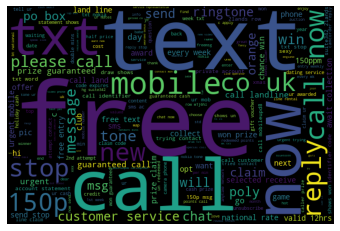

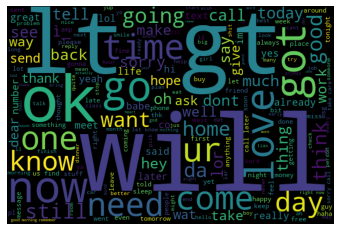

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Thanks for your subscription to Ringtone UK your mobile will be charged å£5/month Please confirm by replying YES or NO. If you reply NO you will not be charged
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify. Get Usher and Britney. FML
You'll not rcv any more msgs from the chat svc. For FREE Hardcore services text GO to: 69988 If u get nothing u must Age Verify with yr network & try again
Customer service annoncement. You have a New Years delivery waiting for you. Please call 07046744435 now to arrange delivery
-PLS STOP bootydelious (32/F) is inviting you to be her friend. Reply YES-434 or NO-434 See her: www.SMS.ac/u/bootydelious STOP? Send STOP FRND to 62468
BangBabes Ur order is on the way. U SHOULD receive

In [ ]:
# https://deeplearningcourses.com/c/data-science-natural-language-processing-in-python
# https://www.udemy.com/data-science-natural-language-processing-in-python

# Author: http://lazyprogrammer.me
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud


# data from:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
# file contains some invalid chars
# depending on which version of pandas you have
# an error may be thrown
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spam.csv', encoding='ISO-8859-1')

# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# rename columns to something better
df.columns = ['labels', 'data']

# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

# try multiple ways of calculating features
tfidf = TfidfVectorizer(decode_error='ignore')
Xtrain = tfidf.fit_transform(df_train)
Xtest = tfidf.transform(df_test)

# count_vectorizer = CountVectorizer(decode_error='ignore')
# Xtrain = count_vectorizer.fit_transform(df_train)
# Xtest = count_vectorizer.transform(df_test)



# create the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))
# exit()


# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

visualize('spam')
visualize('ham')


# see what we're getting wrong
X = tfidf.transform(df['data'])
df['predictions'] = model.predict(X)

# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

# things that should not be spam
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)

# Section 3: Sentiment Analyser

In [ ]:
# This code is for my NLP Udemy class, which can be found at:
# https://deeplearningcourses.com/c/data-science-natural-language-processing-in-python
# https://www.udemy.com/data-science-natural-language-processing-in-python
# It is written in such a way that tells a story.
# i.e. So you can follow a thought process of starting from a
# simple idea, hitting an obstacle, overcoming it, etc.
# i.e. It is not optimized for anything.

# Author: http://lazyprogrammer.me
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import nltk
import numpy as np
from sklearn.utils import shuffle
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup


wordnet_lemmatizer = WordNetLemmatizer() # turns words into base form

# from http://www.lextek.com/manuals/onix/stopwords1.html
stopwords = set(w.rstrip() for w in open('/content/drive/My Drive/Colab Notebooks/stopwords.txt')) 

# note: an alternative source of stopwords
# from nltk.corpus import stopwords
# stopwords.words('english')

# load the reviews
# data courtesy of http://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html
positive_reviews = BeautifulSoup(open('/content/drive/My Drive/Colab Notebooks//positive.review').read(), features="html5lib")
positive_reviews = positive_reviews.findAll('review_text')

negative_reviews = BeautifulSoup(open('/content/drive/My Drive/Colab Notebooks//negative.review').read(), features="html5lib")
negative_reviews = negative_reviews.findAll('review_text')

np.random.shuffle(positive_reviews)
positive_reviews = positive_reviews[:len(negative_reviews)]

# first let's just try to tokenize the text using nltk's tokenizer
# let's take the first review for example:
# t = positive_reviews[0]
# nltk.tokenize.word_tokenize(t.text)
#
# notice how it doesn't downcase, so It != it
# not only that, but do we really want to include the word "it" anyway?
# you can imagine it wouldn't be any more common in a positive review than a negative review
# so it might only add noise to our model.
# so let's create a function that does all this pre-processing for us

def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    return tokens


# create a word-to-index map so that we can create our word-frequency vectors later
# let's also save the tokenized versions so we don't have to tokenize again later
word_index_map = {}
current_index = 0
positive_tokenized = []
negative_tokenized = []
orig_reviews = []

for review in positive_reviews:
    orig_reviews.append(review.text)
    tokens = my_tokenizer(review.text)
    positive_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

for review in negative_reviews:
    orig_reviews.append(review.text)
    tokens = my_tokenizer(review.text)
    negative_tokenized.append(tokens)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1

print("len(word_index_map):", len(word_index_map))

# now let's create our input matrices
def tokens_to_vector(tokens, label):
    x = np.zeros(len(word_index_map) + 1) # last element is for the label
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    x = x / x.sum() # normalize it before setting label
    x[-1] = label
    return x

N = len(positive_tokenized) + len(negative_tokenized)
# (N x D+1 matrix - keeping them together for now so we can shuffle more easily later
data = np.zeros((N, len(word_index_map) + 1))
i = 0
for tokens in positive_tokenized:
    xy = tokens_to_vector(tokens, 1)
    data[i,:] = xy
    i += 1

for tokens in negative_tokenized:
    xy = tokens_to_vector(tokens, 0)
    data[i,:] = xy
    i += 1

# shuffle the data and create train/test splits
# try it multiple times!
orig_reviews, data = shuffle(orig_reviews, data)

X = data[:,:-1]
Y = data[:,-1]

# last 100 rows will be test
Xtrain = X[:-100,]
Ytrain = Y[:-100,]
Xtest = X[-100:,]
Ytest = Y[-100:,]

model = LogisticRegression()
model.fit(Xtrain, Ytrain)
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Test accuracy:", model.score(Xtest, Ytest))


# let's look at the weights for each word
# try it with different threshold values!
threshold = 0.5
for word, index in iteritems(word_index_map):
    weight = model.coef_[0][index]
    if weight > threshold or weight < -threshold:
        print(word, weight)


# check misclassified examples
preds = model.predict(X)
P = model.predict_proba(X)[:,1] # p(y = 1 | x)

# since there are many, just print the "most" wrong samples
minP_whenYis1 = 1
maxP_whenYis0 = 0
wrong_positive_review = None
wrong_negative_review = None
wrong_positive_prediction = None
wrong_negative_prediction = None
for i in range(N):
    p = P[i]
    y = Y[i]
    if y == 1 and p < 0.5:
        if p < minP_whenYis1:
            wrong_positive_review = orig_reviews[i]
            wrong_positive_prediction = preds[i]
            minP_whenYis1 = p
    elif y == 0 and p > 0.5:
        if p > maxP_whenYis0:
            wrong_negative_review = orig_reviews[i]
            wrong_negative_prediction = preds[i]
            maxP_whenYis0 = p

print("Most wrong positive review (prob = %s, pred = %s):" % (minP_whenYis1, wrong_positive_prediction))
print(wrong_positive_review)
print("Most wrong negative review (prob = %s, pred = %s):" % (maxP_whenYis0, wrong_negative_prediction))
print(wrong_negative_review)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
len(word_index_map): 11092
Train accuracy: 0.7842105263157895
Test accuracy: 0.64
've 0.7275290101583333
month -0.7431716440667666
excellent 1.3012264547823789
sound 1.0300814828248415
you 0.9725536095906577
customer -0.7196710721695576
n't -2.1609966793647635
support -0.9279895135903151
wa -1.6292615475537644
happy 0.5586382740619505
video 0.5433696655840697
picture 0.5425023814517355
quality 1.501150464434374
item -0.9929085477675923
price 2.753003511040881
pretty 0.7704725174752631
fast 0.8712799273334357
recommend 0.6998558656128538
using 0.6627067572786605
cable 0.5986831857336052
easy 1.8202180505510128
expected 0.5116063394270297
speaker 0.8626704928589938
laptop 0.5118435001232048
perfect 0.9416843291182918
ha 0.6818004854559037
radio -0.5118860104094201
s

# Section 4: Latent Semantic Analyser

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of errors parsing file: 0 number of lines in file: 2373


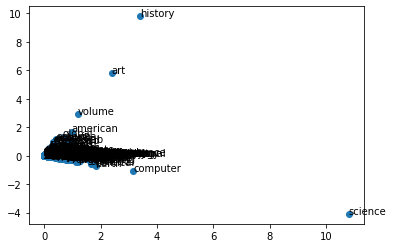

In [ ]:
# Latent semantic analysis visualization for NLP class, which can be found at:
# https://deeplearningcourses.com/c/data-science-natural-language-processing-in-python
# https://www.udemy.com/data-science-natural-language-processing-in-python

# Author: http://lazyprogrammer.me
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import nltk
nltk.download('wordnet')
nltk.download('punkt')
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD


wordnet_lemmatizer = WordNetLemmatizer() # lemmatiser

titles = [line.rstrip() for line in open('/content/drive/My Drive/Colab Notebooks/Data/all_book_titles.txt')] # load book titles into an array

# copy tokenizer from sentiment example
stopwords = set(w.rstrip() for w in open('/content/drive/My Drive/Colab Notebooks/Data/stopwords.txt'))

# note: an alternative source of stopwords
# from nltk.corpus import stopwords
# stopwords.words('english')

# add more stopwords specific to this problem - way of customising stop words!
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })
def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove any digits, i.e. "3rd edition"
    return tokens


# create a word-to-index map so that we can create our word-frequency vectors later
# let's also save the tokenized versions so we don't have to tokenize again later
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
error_count = 0
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8') # this will throw exception if bad characters
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e: 
        print(e)
        print(title)
        error_count += 1


print("Number of errors parsing file:", error_count, "number of lines in file:", len(titles))
if error_count == len(titles):
    print("There is no data to do anything with! Quitting...")
    exit()


# now let's create our input matrices - just indicator variables for this example - works better than proportions
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x

N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # terms will go along rows, documents along columns
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1

def main():
    svd = TruncatedSVD()
    Z = svd.fit_transform(X)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(D):
        plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
    plt.show()

if __name__ == '__main__':
    main()

# Section 5: Article Spinner

In [ ]:
# Very basic article spinner for NLP class, which can be found at:
# https://deeplearningcourses.com/c/data-science-natural-language-processing-in-python
# https://www.udemy.com/data-science-natural-language-processing-in-python

# Author: http://lazyprogrammer.me

# A very bad article spinner using trigrams.
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import nltk
import random
import numpy as np

from bs4 import BeautifulSoup


# load the reviews
# data courtesy of http://www.cs.jhu.edu/~mdredze/datasets/sentiment/index2.html
positive_reviews = BeautifulSoup(open('/content/drive/My Drive/Colab Notebooks/Data/positive.review').read())
positive_reviews = positive_reviews.findAll('review_text')


# extract trigrams and insert into dictionary
# (w1, w3) is the key, [ w2 ] are the values
trigrams = {}
for review in positive_reviews:
    s = review.text.lower()
    tokens = nltk.tokenize.word_tokenize(s)
    for i in range(len(tokens) - 2):
        k = (tokens[i], tokens[i+2])
        if k not in trigrams:
            trigrams[k] = []
        trigrams[k].append(tokens[i+1])

# turn each array of middle-words into a probability vector
trigram_probabilities = {}
for k, words in iteritems(trigrams):
    # create a dictionary of word -> count
    if len(set(words)) > 1:
        # only do this when there are different possibilities for a middle word
        d = {}
        n = 0
        for w in words:
            if w not in d:
                d[w] = 0
            d[w] += 1
            n += 1
        for w, c in iteritems(d):
            d[w] = float(c) / n
        trigram_probabilities[k] = d


def random_sample(d):
    # choose a random sample from dictionary where values are the probabilities
    r = random.random()
    cumulative = 0
    for w, p in iteritems(d):
        cumulative += p
        if r < cumulative:
            return w


def test_spinner():
    review = random.choice(positive_reviews)
    s = review.text.lower()
    print("Original:", s)
    tokens = nltk.tokenize.word_tokenize(s)
    for i in range(len(tokens) - 2):
        if random.random() < 0.2: # 20% chance of replacement
            k = (tokens[i], tokens[i+2])
            if k in trigram_probabilities:
                w = random_sample(trigram_probabilities[k])
                tokens[i+1] = w
    print("Spun:")
    print(" ".join(tokens).replace(" .", ".").replace(" '", "'").replace(" ,", ",").replace("$ ", "$").replace(" !", "!"))#.replace(" '", "'")


if __name__ == '__main__':
    test_spinner()

Original: 
this remote will do everything you need or want. simple to use and great customer service. i had a couple of "glitches" (buttons that didn't work quite right) when i first programmed the device, but the harmony support team helped me through those areas. the changes needed are now permanently in my data area on the harmony web site so if i ever need to, all i have to do is reload the info.

like another reviewer, i also have a tivo (2 actually) and the only button that wouldn't work on my harmony 680 was the "clear" button. customer service fixed that in a jiffy, too.

i have owned several multiple device remotes over the years and never had one so good that i could really put away all my other remotes. i now only use one - the harmony 680. fantastic device! i'd give it 6 stars if i could

Spun:
this remote will do everything you need or want. simple to use and great customer service. i had a couple of `` pure'' ( buttons that did n't work quite right ). i first programmed t